In [1]:
#NDWI load packages

import datacube

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import rgb


In [2]:
# connect to datacube

dc = datacube.Datacube(app="07_Parallel_processing_with_Dask")

In [3]:
#Enable Dask

client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/saintly28@hotmail.com/proxy/8787/status,
Dashboard: /user/saintly28@hotmail.com/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39373,Workers: 1
Dashboard: /user/saintly28@hotmail.com/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:34397,Total threads: 2
Dashboard: /user/saintly28@hotmail.com/proxy/44595/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:33323,


In [4]:
# Lazy load data 

lazy_ds = dc.load(product=["ga_ls5t_ard_3", "ga_ls7e_ard_3", "ga_ls8c_ard_3",
                  "ga_ls9c_ard_3"],
                  measurements=["nbart_green", "nbart_red", "nbart_blue", "nbart_nir", "nbart_swir_2", "oa_fmask"],
                  x=(150.06, 149.36),
                  y=(-37.50, -37.25),
                  time=('2020-01-14', '2020-04-14'),
                  dask_chunks={"time": 1, "x": 2048, "y": 2048})
resampling={
                   "fmask": "nearest",
                   "*": "bilinear"
               },



lazy_ds

<xarray.Dataset>
Dimensions:       (time: 21, y: 1199, x: 2184)
Coordinates:
  * time          (time) datetime64[ns] 2020-01-16T23:51:15.831480 ... 2020-0...
  * y             (y) float64 -4.177e+06 -4.177e+06 ... -4.212e+06 -4.213e+06
  * x             (x) float64 1.538e+06 1.538e+06 ... 1.603e+06 1.603e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) int16 dask.array<chunksize=(1, 1199, 2048), meta=np.ndarray>
    nbart_red     (time, y, x) int16 dask.array<chunksize=(1, 1199, 2048), meta=np.ndarray>
    nbart_blue    (time, y, x) int16 dask.array<chunksize=(1, 1199, 2048), meta=np.ndarray>
    nbart_nir     (time, y, x) int16 dask.array<chunksize=(1, 1199, 2048), meta=np.ndarray>
    nbart_swir_2  (time, y, x) int16 dask.array<chunksize=(1, 1199, 2048), meta=np.ndarray>
    oa_fmask      (time, y, x) uint8 dask.array<chunksize=(1, 1199, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [ ]:
# check variable names

# Chris help with script please

In [5]:
# view dask chunks

lazy_ds.nbart_red.data


dask.array<dc_load_nbart_red, shape=(21, 1199, 2184), dtype=int16, chunksize=(1, 1199, 2048), chunktype=numpy.ndarray>

In [6]:
# Import tools to mask data for cloud

import scipy.ndimage
import xarray
import numpy
import datacube
from datacube.utils.masking import make_mask
from datacube.utils.masking import mask_invalid_data
from odc.algo import mask_cleanup

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.plotting import rgb

In [7]:
# app

dc = datacube.Datacube(app="Masking_data")

In [8]:
# flags

lazy_ds.oa_fmask.attrs["flags_definition"]

{'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'nodata',
   '1': 'valid',
   '2': 'cloud',
   '3': 'shadow',
   '4': 'snow',
   '5': 'water'},
  'description': 'Fmask'}}

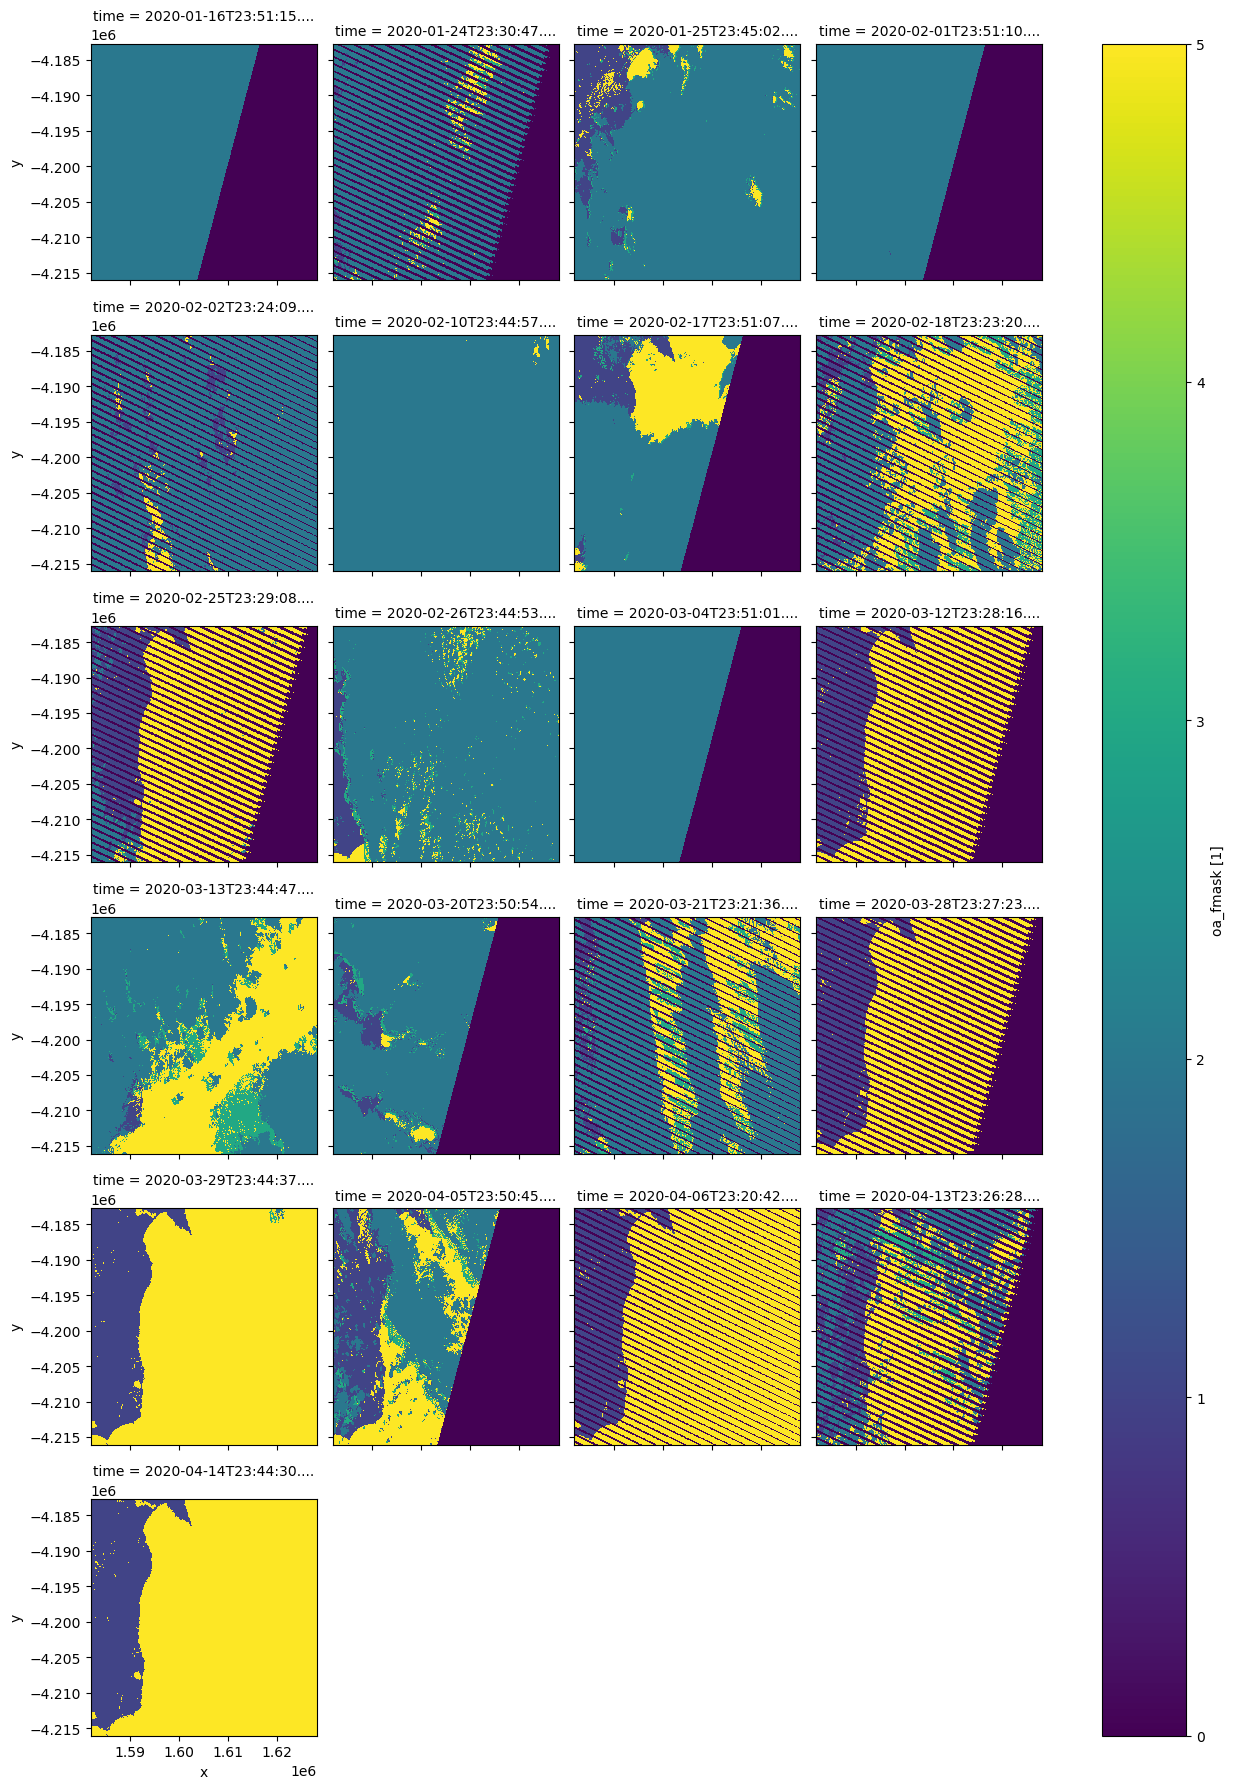

In [10]:
# plot

lazy_ds.oa_fmask.plot(col="time", col_wrap=4)

In [9]:
# Create the mask based on "valid" pixels

clear_mask = make_mask(lazy_ds.oa_fmask, fmask="valid")
clear_mask.plot(col="time", col_wrap=4)

In [10]:
# Apply the mask

clear = lazy_ds.where(clear_mask)

In [11]:
# Identify pixels that are either "valid", "water" or "snow"

cloud_free_mask = (
    make_mask(lazy_ds.oa_fmask, fmask="valid") | 
    make_mask(lazy_ds.oa_fmask, fmask="water") | 
    make_mask(lazy_ds.oa_fmask, fmask="snow")
)

# Apply the mask
cloud_free = lazy_ds.where(cloud_free_mask)

In [12]:
# Set invalid nodata pixels to NaN

valid_data = lazy_ds.oa_fmask.plot
valid_data

In [13]:
# Identify pixels that are either "cloud" or "cloud_shadow"

cloud_shadow_mask = (
    make_mask(lazy_ds.oa_fmask, fmask="cloud") | 
    make_mask(lazy_ds.oa_fmask, fmask="shadow")
)


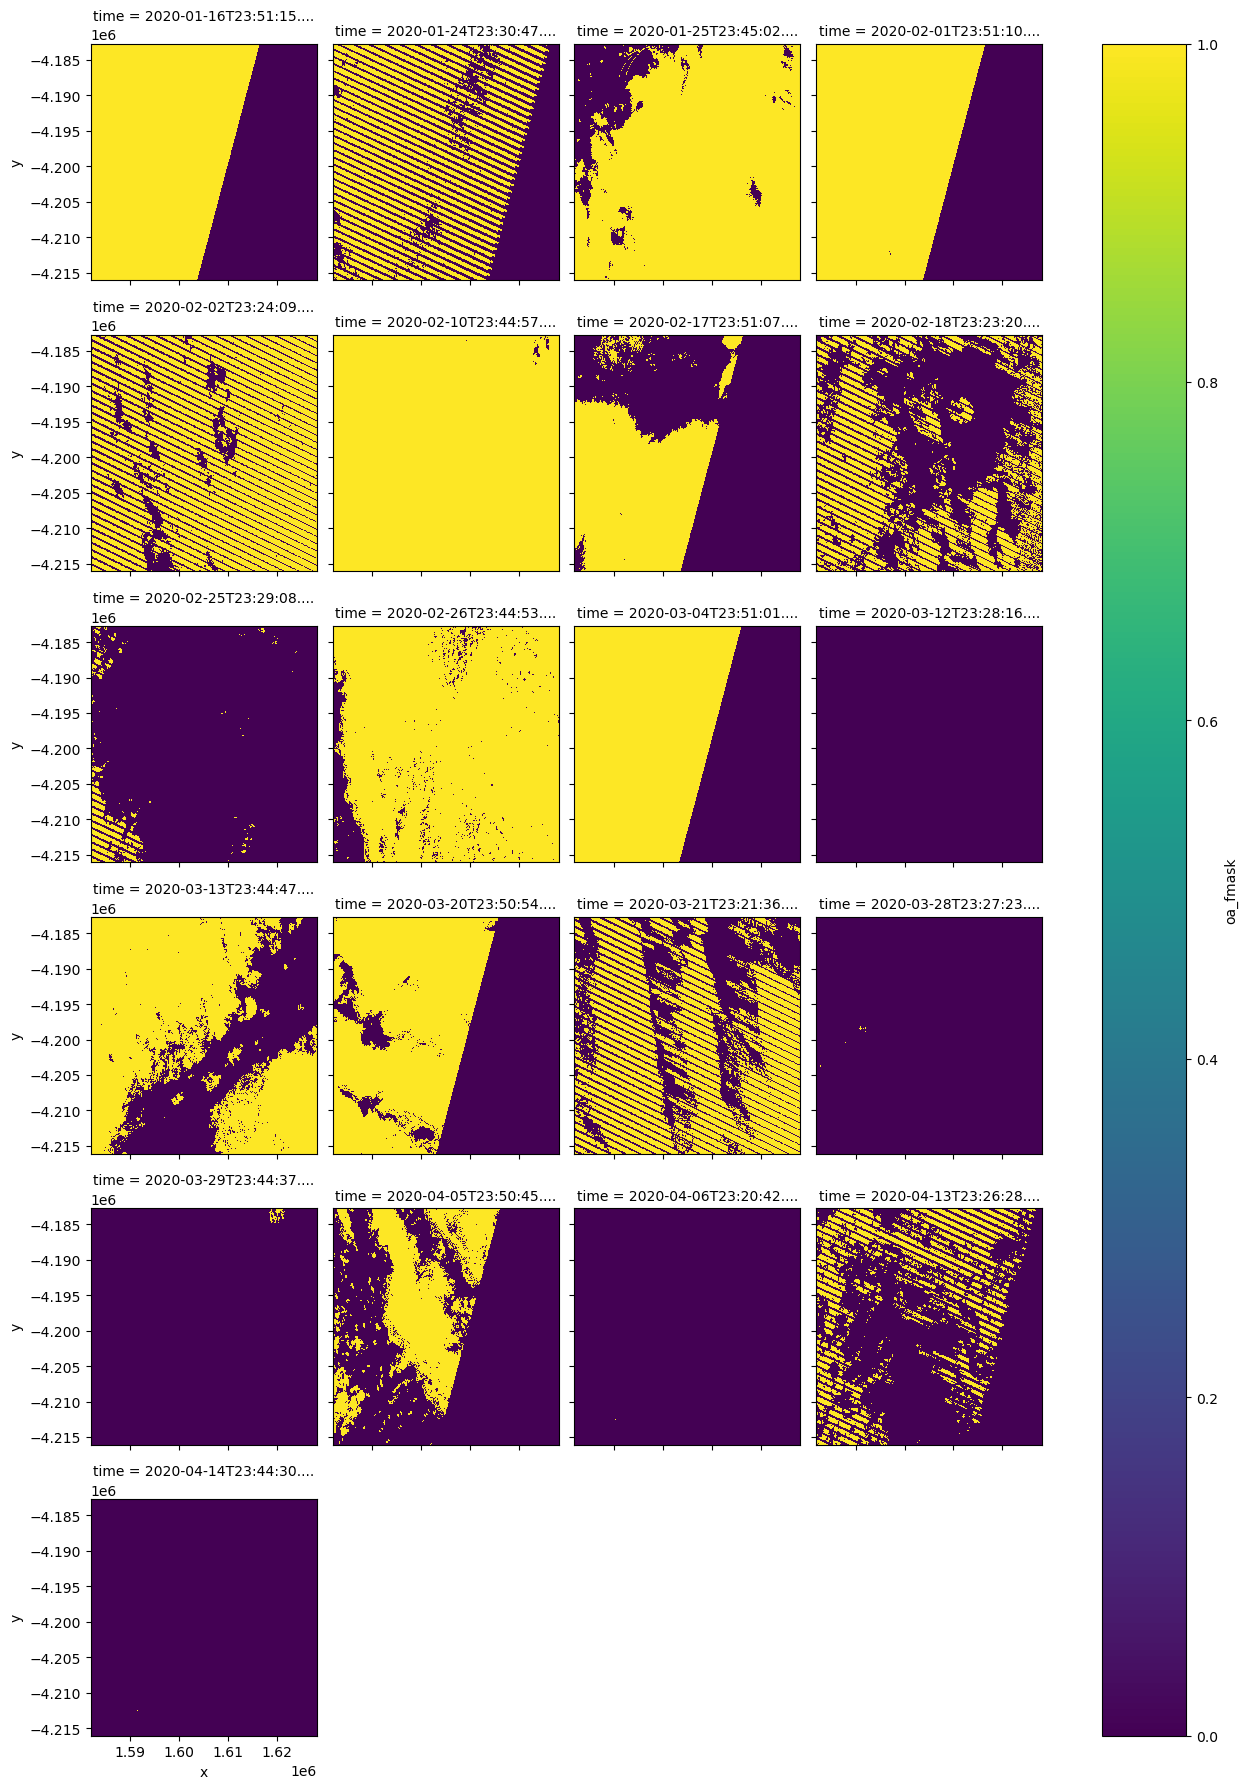

In [16]:
# Plot cloud shadow mask

cloud_shadow_mask.plot(col="time", col_wrap=4)

In [14]:
# Dilate all cloud and cloud shadow pixels by 5 pixels in all directions

cloud_shadow_buffered = mask_cleanup(mask=cloud_shadow_mask,
                                     mask_filters=[("dilation", 5)])

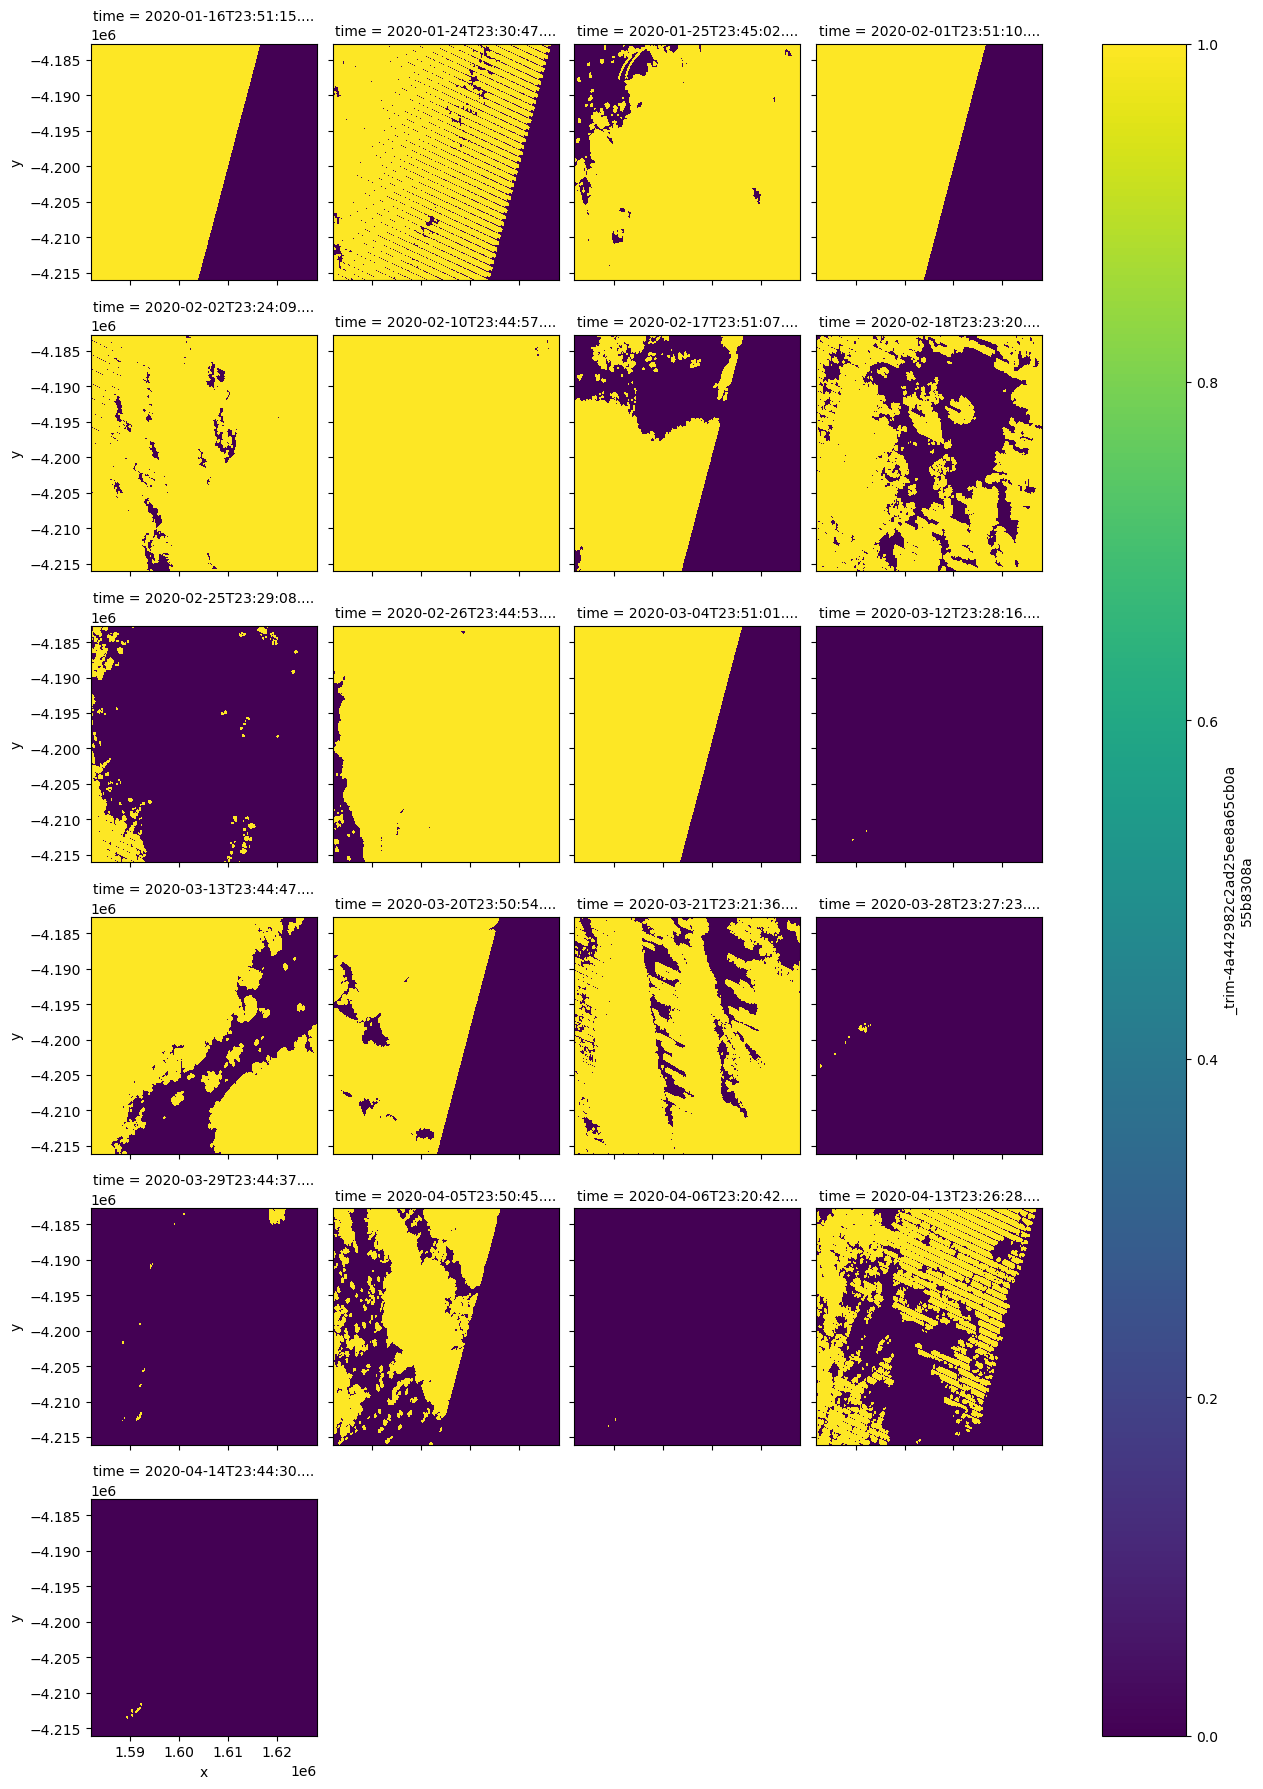

In [18]:
# Plot cloud shadow buffered

cloud_shadow_buffered.plot(col="time", col_wrap=4)

In [15]:
# Apply the mask

buffered_cloud_free = lazy_ds.where(~cloud_shadow_buffered)

In [16]:
# Set invalid nodata pixels to NaN

valid_data = mask_invalid_data(buffered_cloud_free)

In [17]:
valid_data.nbart_red.isel(time=1)


<xarray.DataArray 'nbart_red' (y: 1199, x: 2184)>
dask.array<getitem, shape=(1199, 2184), dtype=float64, chunksize=(1199, 2048), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 2020-01-24T23:30:47.774660
  * y            (y) float64 -4.177e+06 -4.177e+06 ... -4.212e+06 -4.213e+06
  * x            (x) float64 1.538e+06 1.538e+06 ... 1.603e+06 1.603e+06
    spatial_ref  int32 3577
Attributes:
    units:         1
    nodata:        -999
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [18]:
# Loading Lazy Data

loaded_ds = valid_data.load()
loaded_ds

<xarray.Dataset>
Dimensions:       (time: 21, y: 1199, x: 2184)
Coordinates:
  * time          (time) datetime64[ns] 2020-01-16T23:51:15.831480 ... 2020-0...
  * y             (y) float64 -4.177e+06 -4.177e+06 ... -4.212e+06 -4.213e+06
  * x             (x) float64 1.538e+06 1.538e+06 ... 1.603e+06 1.603e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) float64 nan nan nan nan ... 145.0 145.0 145.0
    nbart_red     (time, y, x) float64 nan nan nan nan ... 79.0 73.0 82.0 72.0
    nbart_blue    (time, y, x) float64 nan nan nan nan ... 266.0 268.0 273.0
    nbart_nir     (time, y, x) float64 nan nan nan nan ... 40.0 38.0 37.0 42.0
    nbart_swir_2  (time, y, x) float64 nan nan nan nan ... 17.0 16.0 15.0 11.0
    oa_fmask      (time, y, x) float64 nan nan nan nan nan ... 5.0 5.0 5.0 5.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [19]:
# check, loaded_ds or valid_data
valid_data

<xarray.Dataset>
Dimensions:       (time: 21, y: 1199, x: 2184)
Coordinates:
  * time          (time) datetime64[ns] 2020-01-16T23:51:15.831480 ... 2020-0...
  * y             (y) float64 -4.177e+06 -4.177e+06 ... -4.212e+06 -4.213e+06
  * x             (x) float64 1.538e+06 1.538e+06 ... 1.603e+06 1.603e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) float64 nan nan nan nan ... 145.0 145.0 145.0
    nbart_red     (time, y, x) float64 nan nan nan nan ... 79.0 73.0 82.0 72.0
    nbart_blue    (time, y, x) float64 nan nan nan nan ... 266.0 268.0 273.0
    nbart_nir     (time, y, x) float64 nan nan nan nan ... 40.0 38.0 37.0 42.0
    nbart_swir_2  (time, y, x) float64 nan nan nan nan ... 17.0 16.0 15.0 11.0
    oa_fmask      (time, y, x) float64 nan nan nan nan nan ... 5.0 5.0 5.0 5.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [20]:
# calc mNDWI

band_diff = loaded_ds.nbart_green - loaded_ds.nbart_swir_2
band_sum = loaded_ds.nbart_green + loaded_ds.nbart_swir_2

loaded_ds["mndwi"] = band_diff / band_sum

In [21]:
loaded_ds

<xarray.Dataset>
Dimensions:       (time: 21, y: 1199, x: 2184)
Coordinates:
  * time          (time) datetime64[ns] 2020-01-16T23:51:15.831480 ... 2020-0...
  * y             (y) float64 -4.177e+06 -4.177e+06 ... -4.212e+06 -4.213e+06
  * x             (x) float64 1.538e+06 1.538e+06 ... 1.603e+06 1.603e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) float64 nan nan nan nan ... 145.0 145.0 145.0
    nbart_red     (time, y, x) float64 nan nan nan nan ... 79.0 73.0 82.0 72.0
    nbart_blue    (time, y, x) float64 nan nan nan nan ... 266.0 268.0 273.0
    nbart_nir     (time, y, x) float64 nan nan nan nan ... 40.0 38.0 37.0 42.0
    nbart_swir_2  (time, y, x) float64 nan nan nan nan ... 17.0 16.0 15.0 11.0
    oa_fmask      (time, y, x) float64 nan nan nan nan nan ... 5.0 5.0 5.0 5.0
    mndwi         (time, y, x) float64 nan nan nan nan ... 0.8012 0.8125 0.859
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [22]:
loaded_ds.mndwi

<xarray.DataArray 'mndwi' (time: 21, y: 1199, x: 2184)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.23838631, -0.20267803, -0.22553191, ...,         nan,
                 nan,         nan],
        [-0.24634146, -0.23254402, -0.26405451, ...,         nan,
                 nan,         nan],
        [-0.25394897, -0.25394897, -0.2752193 , ...,         nan,
                 nan,         nan],
...
        [-0.3476298 , -0.47595682, -0.35208333, ...,  0.55897436,
          0.35483871,  0.68148148],
        [-0.30252101, -0.45178571, -0.35372069, ...,  0.98947368,
          0.35483871,  0.43217666],
        [-0.38081108, -0.38238141, -0.38301887, ...,  0.68148148,
          0.43217666,  0.99122807]],

       [[        nan,         nan,         nan, ...,  0.81927711,
          0.83908046,  0.77380952],
        [        nan,         nan,         nan, ...,  0.83233533,
          0.83815029,  0.78034682],
        [        nan,         nan,         nan, ...,  0.80232558,
          0.81065089,  0.86419753],
        ...,
        [        nan,         nan,         nan, ...,  0.82389937,
          0.81481481,  0.8136646 ],
        [        nan,         nan,         nan, ...,  0.85987261,
          0.81818182,  0.8       ],
        [        nan,         nan,         nan, ...,  0.80124224,
          0.8125    ,  0.85897436]]])
Coordinates:
  * time         (time) datetime64[ns] 2020-01-16T23:51:15.831480 ... 2020-04...
  * y            (y) float64 -4.177e+06 -4.177e+06 ... -4.212e+06 -4.213e+06
  * x            (x) float64 1.538e+06 1.538e+06 ... 1.603e+06 1.603e+06
    spatial_ref  int32 3577

In [ ]:
# help this doesn't work I don't know why do I even need it ?

import matplotlib.pyplot as plt

# Assuming `mndwi` is your DataArray variable

# Plot the mNDWI data
plt.imshow(mndwi)
plt.colorbar()
plt.title("mndwi")
plt.show()

In [28]:
# make data an XArray from Dask DO NOT NEED FOR OUTPUT

ndwi_load = valid_data.mndwi.load()
ndwi_load

<xarray.DataArray 'mndwi' (time: 21, y: 1113, x: 1540)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.59851301, -0.61664393, -0.61214165, ...,  0.79381443,
          0.80434783,  0.79234973],
        [-0.61793103, -0.61793103, -0.61862528, ...,  0.87165775,
          0.82702703,  0.78378378],
        [-0.61067504, -0.63270963, -0.64078325, ...,  0.80851064,
          0.83068783,  0.82222222],
        ...,
        [ 0.76216216,  0.75661376,  0.77777778, ...,  0.83431953,
          0.81609195,  0.78531073],
        [ 0.72682927,  0.73604061,  0.75      , ...,  0.79661017,
          0.79545455,  0.79545455],
        [ 0.73469388,  0.71859296,  0.68844221, ...,  0.79661017,
          0.86046512,  0.8       ]]])
Coordinates:
  * time         (time) datetime64[ns] 2020-01-16T23:51:15.831480 ... 2020-04...
  * y            (y) float64 -4.183e+06 -4.183e+06 ... -4.216e+06 -4.216e+06
  * x            (x) float64 1.582e+06 1.582e+06 ... 1.628e+06 1.628e+06
    spatial_ref  int32 3577

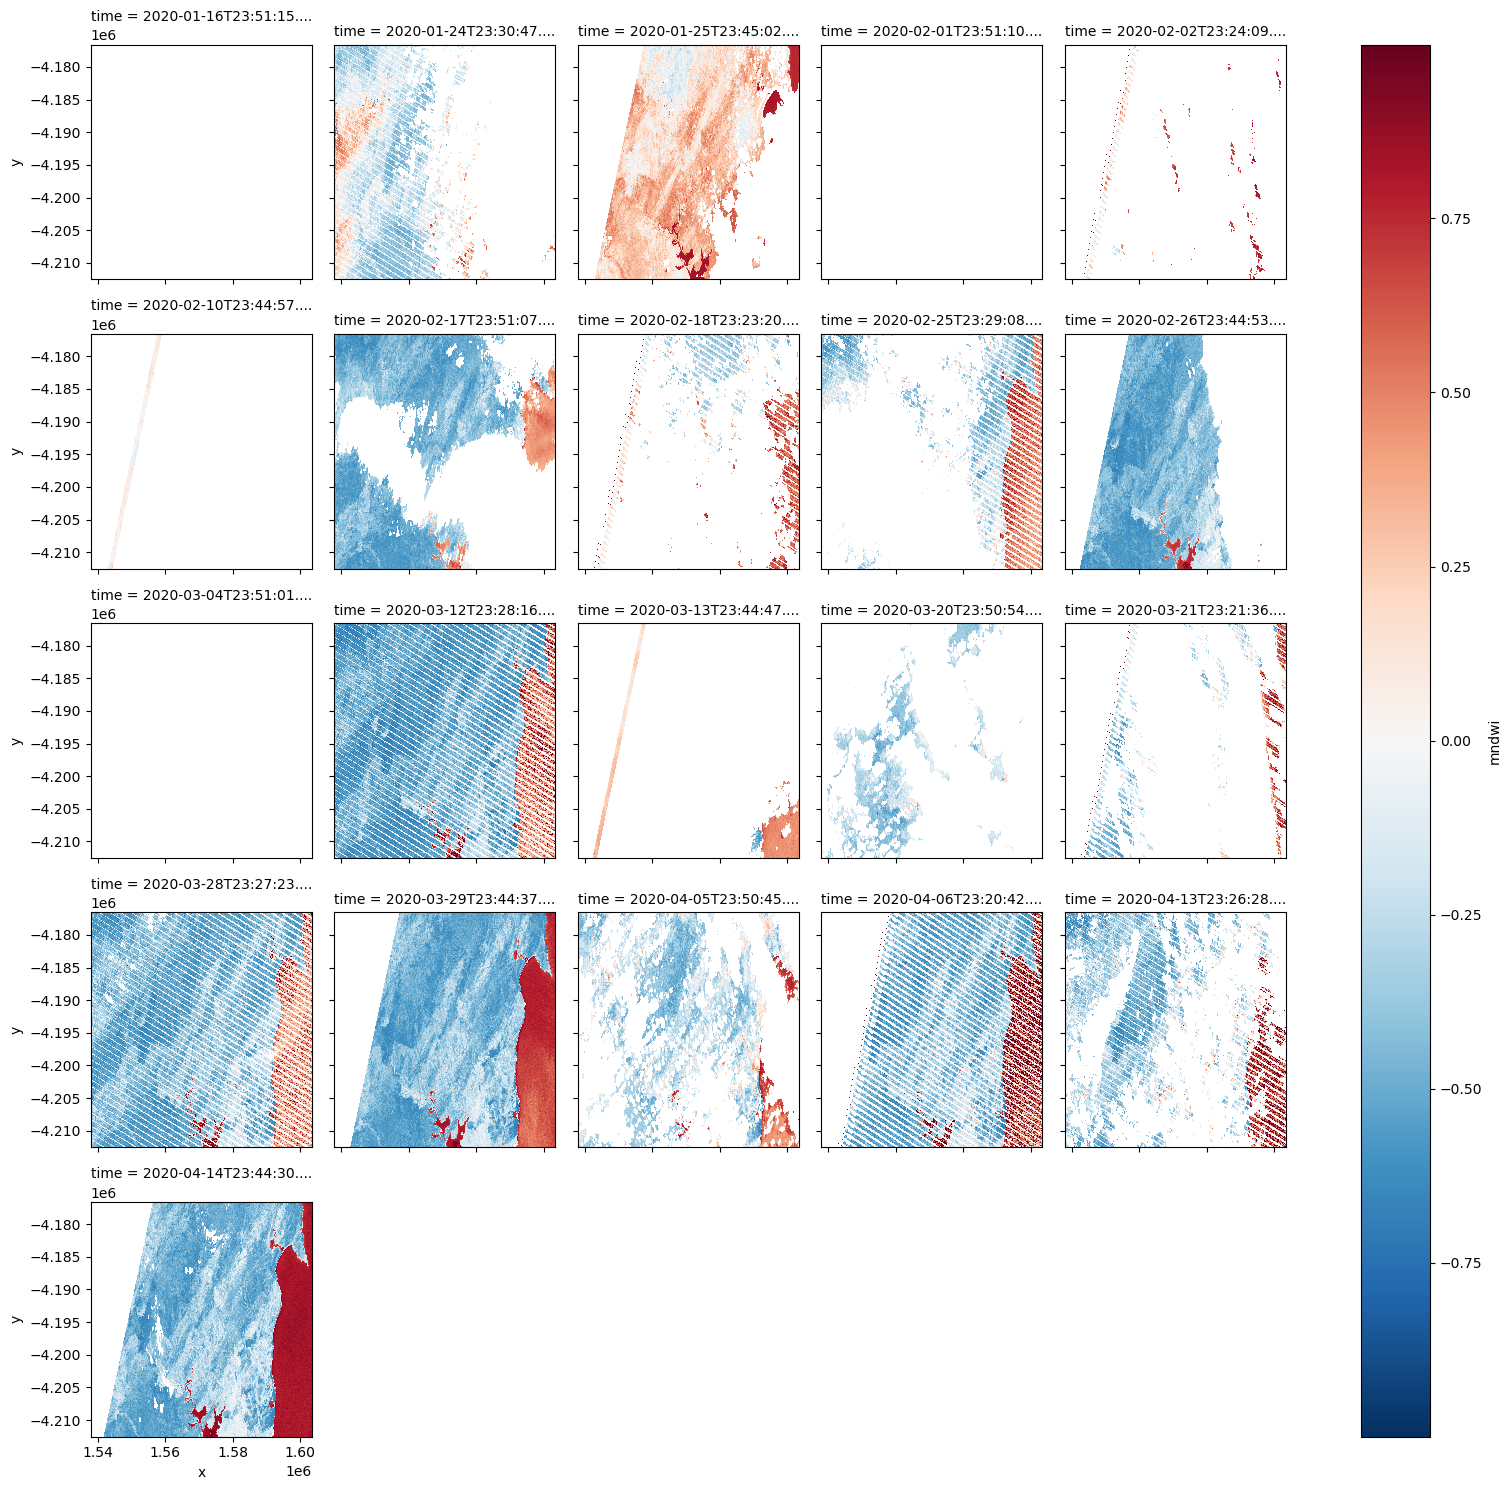

In [23]:
# plot data 

loaded_ds.mndwi.plot(col='time', col_wrap=5)

In [34]:
ndwi_load

<xarray.DataArray 'mndwi' (time: 21, y: 1113, x: 1540)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.59851301, -0.61664393, -0.61214165, ...,  0.79381443,
          0.80434783,  0.79234973],
        [-0.61793103, -0.61793103, -0.61862528, ...,  0.87165775,
          0.82702703,  0.78378378],
        [-0.61067504, -0.63270963, -0.64078325, ...,  0.80851064,
          0.83068783,  0.82222222],
        ...,
        [ 0.76216216,  0.75661376,  0.77777778, ...,  0.83431953,
          0.81609195,  0.78531073],
        [ 0.72682927,  0.73604061,  0.75      , ...,  0.79661017,
          0.79545455,  0.79545455],
        [ 0.73469388,  0.71859296,  0.68844221, ...,  0.79661017,
          0.86046512,  0.8       ]]])
Coordinates:
  * time         (time) datetime64[ns] 2020-01-16T23:51:15.831480 ... 2020-04...
  * y            (y) float64 -4.183e+06 -4.183e+06 ... -4.216e+06 -4.216e+06
  * x            (x) float64 1.582e+06 1.582e+06 ... 1.628e+06 1.628e+06
    spatial_ref  int32 3577

In [24]:
# create binary water not water data

import rasterio
import xarray as xr

# Extract the NDWI data variable COULD BE WRONG WORKS WITHOUT
ndwi_variable = loaded_ds.mndwi

# Set the threshold
threshold = 0.3  # Adjust as per your requirement

# Create a binary water or no water raster
binary_data = ndwi_variable > threshold

#binary_data = binary_date.dtype('uint8')

In [25]:
# Calculate total wetness through time
wet_pixels = binary_data.sum(dim=['time'])

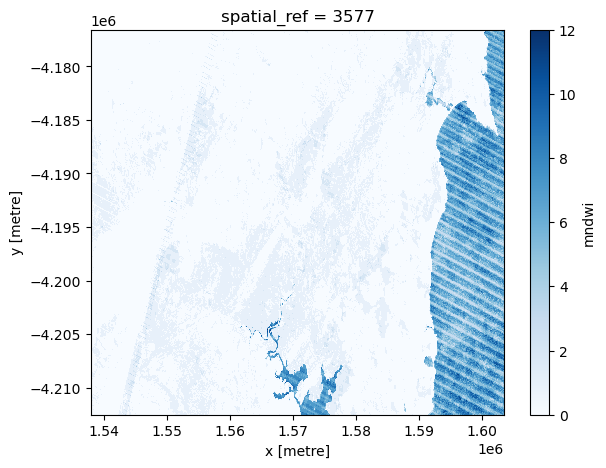

In [26]:
wet_pixels.plot(size=5, cmap='Blues')

In [27]:
wet_pixels.attrs = loaded_ds.attrs

In [28]:
wet_pixels

<xarray.DataArray 'mndwi' (y: 1199, x: 2184)>
array([[0, 0, 0, ..., 9, 7, 7],
       [0, 0, 0, ..., 9, 9, 8],
       [0, 0, 0, ..., 7, 9, 9],
       ...,
       [0, 0, 0, ..., 7, 6, 7],
       [0, 0, 0, ..., 7, 8, 7],
       [0, 0, 0, ..., 6, 7, 5]])
Coordinates:
  * y            (y) float64 -4.177e+06 -4.177e+06 ... -4.212e+06 -4.213e+06
  * x            (x) float64 1.538e+06 1.538e+06 ... 1.603e+06 1.603e+06
    spatial_ref  int32 3577
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [29]:
wet_pixels

<xarray.DataArray 'mndwi' (y: 1199, x: 2184)>
array([[0, 0, 0, ..., 9, 7, 7],
       [0, 0, 0, ..., 9, 9, 8],
       [0, 0, 0, ..., 7, 9, 9],
       ...,
       [0, 0, 0, ..., 7, 6, 7],
       [0, 0, 0, ..., 7, 8, 7],
       [0, 0, 0, ..., 6, 7, 5]])
Coordinates:
  * y            (y) float64 -4.177e+06 -4.177e+06 ... -4.212e+06 -4.213e+06
  * x            (x) float64 1.538e+06 1.538e+06 ... 1.603e+06 1.603e+06
    spatial_ref  int32 3577
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [30]:
#wet_pixels = wo.isel(time=-0).to_array()

from datacube.utils.cog import write_cog

write_cog (geo_im=wet_pixels,
          fname='./Binary_NDWI_sum.tif',
          overwrite=True)

PosixPath('Binary_NDWI_sum.tif')

In [ ]:
# what is below? I think this is doing the same thing as above in dask array not xarray

valid_data["mndwi"] = band_diff / band_sum
valid_data

In [ ]:
mndwi_compute = valid_data.mndwi.compute()
mndwi_compute

In [ ]:
valid_data

In [ ]:
# Calculate mean wetness through time
wo_freq = valid_data.mean(dim=['time'])

In [ ]:
#Calculate max wetness through time
wo_max = valid_data.sum(dim=['time'])

In [ ]:
from datacube.utils.cog import write_cog

In [ ]:
# Run `write_cog`
wo_max = write_cog(geo_im=valid_data.isel(time=0).to_array(), 
                   fname='NDWI_geotiff.tif',
                   overwrite=True)

# Compute the result
result = valid_data.compute()

# Print the result
print(result)